In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

base_dir = os.path.abspath(".\\dataset")

train_dir = os.path.join(base_dir, "processed\\train")
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

classes = [class_name for class_name in os.listdir(train_dir)]

def create_df(folder_path) :
    all_images = []    
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

print()
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

## Menampilkan gambar per kelas

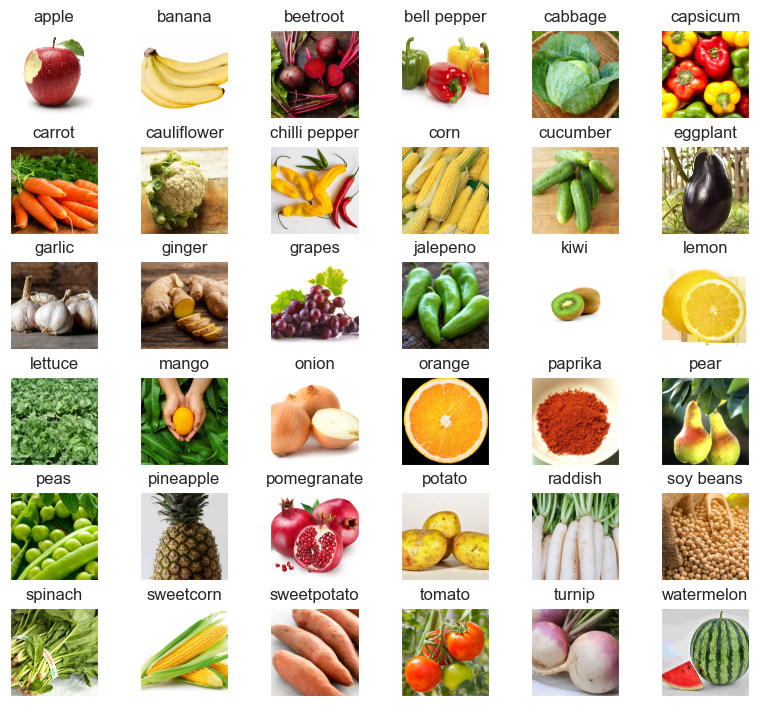

In [ ]:
# Buat DataFrame dengan satu Label untuk setiap kategori
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Tampilkan beberapa gambar kumpulan data
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
)

Found 3114 validated image filenames belonging to 36 classes.


In [3]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


## Menambahkan model MobileNetV2

In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

In [ ]:
for layer in pre_trained_model.layers :
    print(layer.name)

input_layer
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_ex

In [ ]:
# Bekukan semua lapisan, kecuali lapisan terakhir
# Tujuannya adalah untuk melatih lapisan terakhir model yang telah dilatih sebelumnya

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [ ]:
# Menambahkan layer custom di atas model utama
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

## Model Diagram

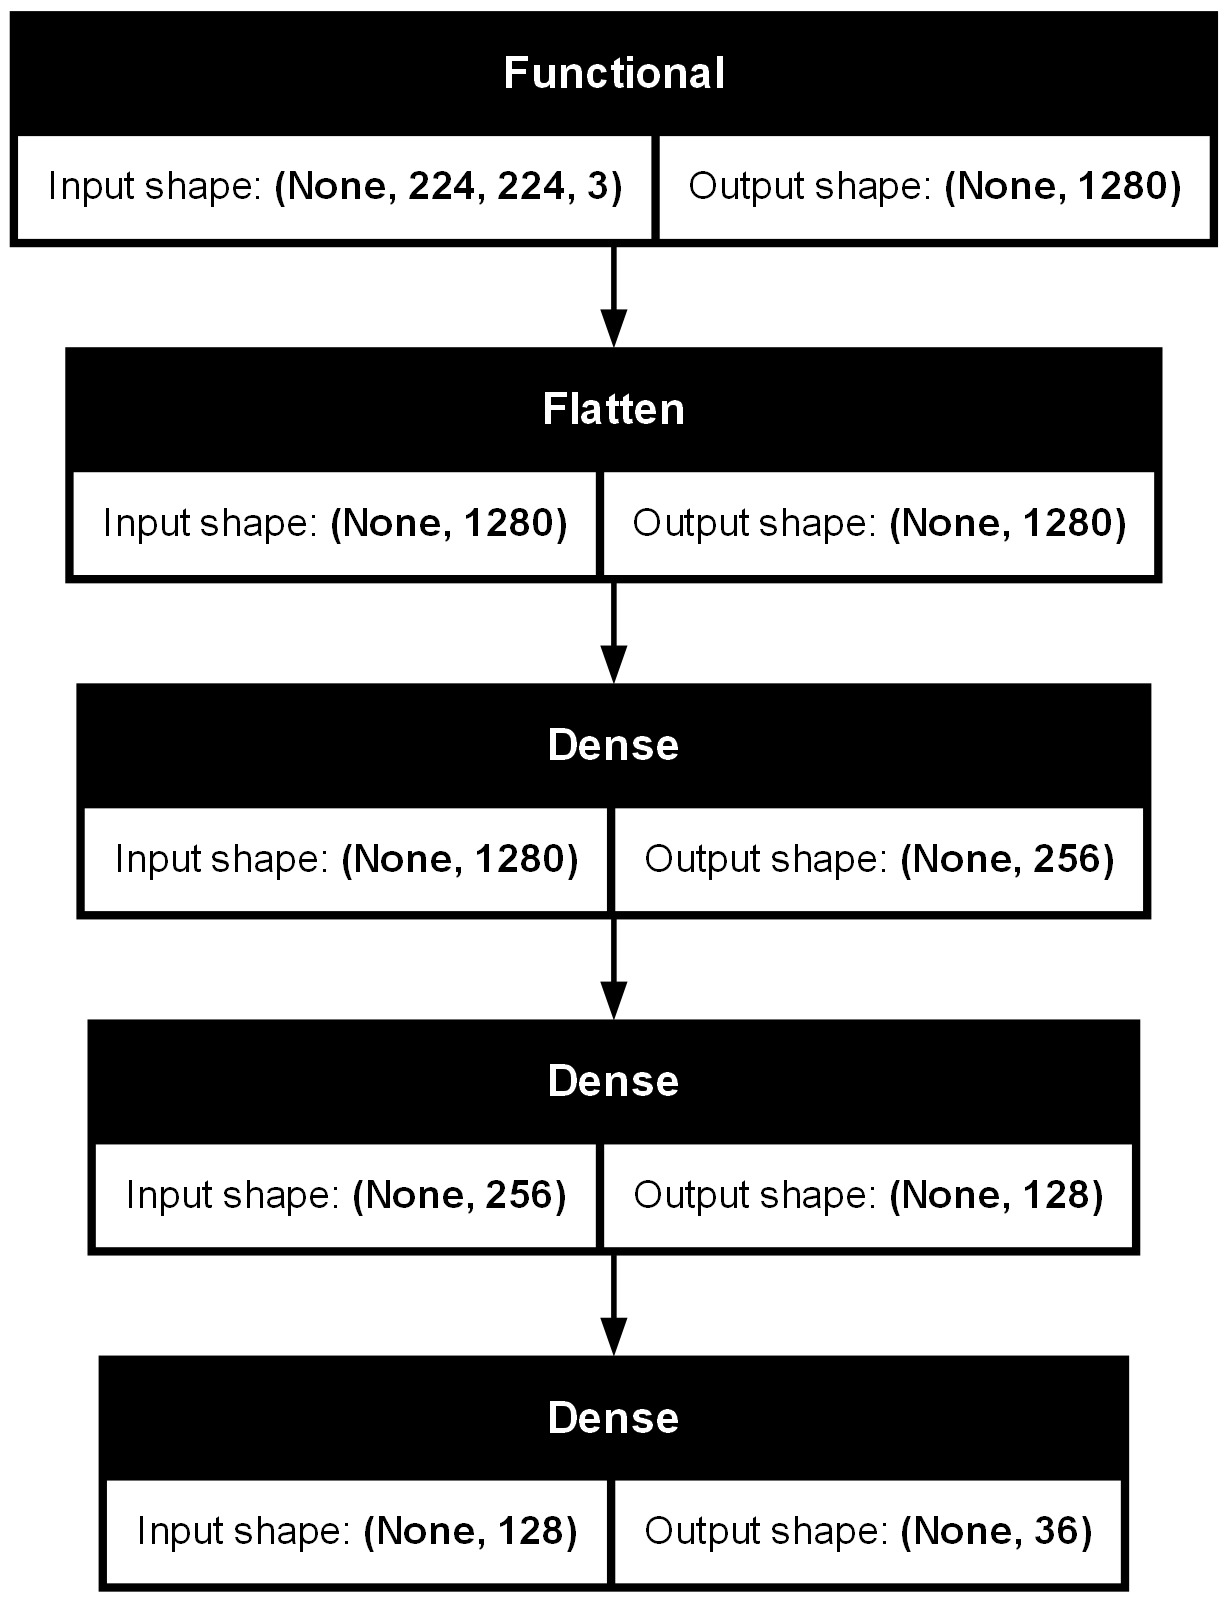

In [ ]:
model.build(input_shape=(None, 224, 224, 3))  # None untuk batch size yang fleksibel
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,623,460 (10.01 MB)

 Trainable params: 1,251,556 (4.77 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

## Compile Model

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

## Latih Model

In [ ]:
# Model Checkpoint
checkpoint_cb = ModelCheckpoint('FoodCF.keras', save_best_only=True) 

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Calculate the number of samples in each set
num_train_samples = len(train_df)
num_validation_samples = len(validation_df)
num_test_samples = len(test_df)

# Calculate steps per epoch
steps_per_epoch = num_train_samples // 32
validation_steps = num_validation_samples // 32

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8987 - loss: 0.2871 - val_accuracy: 0.8344 - val_loss: 0.5055 - learning_rate: 1.5625e-05
Epoch 2/50
 1/97 ━━━━━━━━━━━━━━━━━━━━ 46s 486ms/step - accuracy: 0.9375 - loss: 0.2714

C:\ProgramData\Anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9375 - loss: 0.2714 - val_accuracy: 1.0000 - val_loss: 0.0724 - learning_rate: 1.5625e-05
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9148 - loss: 0.2790 - val_accuracy: 0.8562 - val_loss: 0.4417 - learning_rate: 1.5625e-05
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9375 - loss: 0.2485 - val_accuracy: 0.9677 - val_loss: 0.0661 - learning_rate: 1.5625e-05
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9058 - loss: 0.2857 - val_accuracy: 0.8719 - val_loss: 0.3647 - learning_rate: 1.5625e-05
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8438 - loss: 0.4551 - val_accuracy: 1.0000 - val_loss: 0.0440 - learning_rate: 1.5625e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9239 - loss: 0.2431 - val_accuracy: 0.8781 - val_loss: 0.3323 - learning_rate: 1.5625e-05
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 1.0000 - loss: 0.2

## Evaluasi Model

In [ ]:
# checkpoint callback, simpan bobot model dasar di "FoodCF.keras".
best_model = models.load_model('FoodCF.keras')

In [ ]:
test_loss, test_acc = best_model.evaluate(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8969 - loss: 0.2352
Test Loss : 0.167
Test Accuracy : 0.93


In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluasi kinerja model pada set validasi dan cetak laporan klasifikasi.

    Parameter:
    - model : Model yang terlatih.
    - val_generator: Generator data validasi.
    - class_labels : Daftar nama kelas.
    
    Returns:
    - laporan: Laporan klasifikasi sebagai string.
    """
    
    # Ambil semua label sebenarnya untuk set validasi
    true_labels = val_generator.classes

    # Ambil label kelas (nama) dari generator
    class_labels = list(val_generator.class_indices.keys())

    # Untuk mendapatkan label prediksi, kami memprediksi menggunakan model
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Ambil argmax untuk mendapatkan indeks kelas yang diprediksi.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Mengekstrak label sebenarnya dari generator validasi
    true_labels = val_generator.classes

    # Laporan klasifikasi
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Tentukan peta warna khusus
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix menggunakan seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
               precision    recall  f1-score   support

        apple       0.88      0.70      0.78        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.70      0.78      0.74         9
      cabbage       1.00      1.00      1.00        10
     capsicum       0.80      0.80      0.80        10
       carrot       0.89      0.89      0.89         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.75      1.00      0.86         9
         corn       1.00      0.30      0.46        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      0.90      0.95        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.75      1.00      0.86         9
         kiwi       1.00 

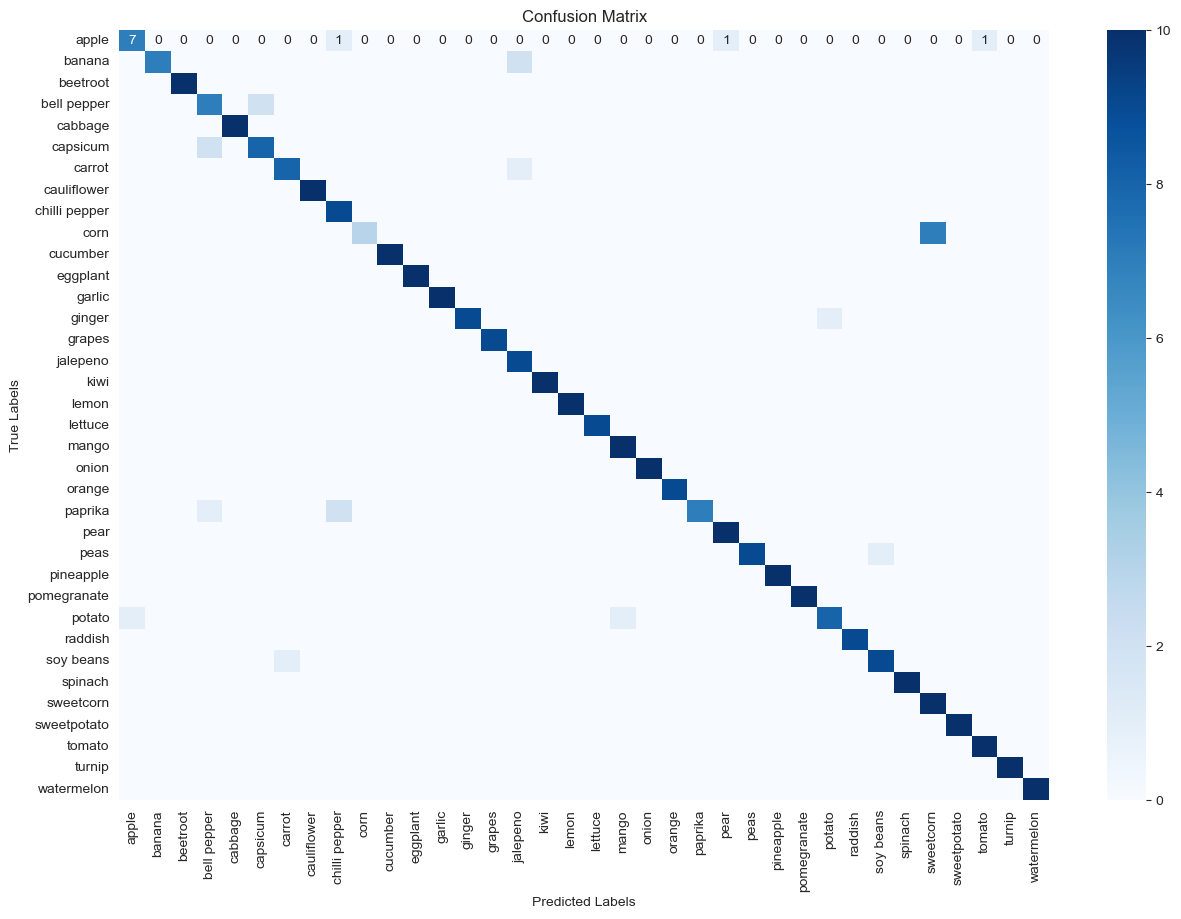

In [ ]:
evaluate_model_performance(best_model, validation_generator, classes)